run this cell to import necessary libraries and load needed files

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import searoute as sr
from scgraph.geographs.marnet import marnet_geograph
import geopandas as gpd
import pandas as pd
import os
import pickle
import re

stops_df = pd.read_csv('MOTHER_TABLE.csv').drop('Unnamed: 0', axis=1).dropna(how='all', axis=0).dropna(how='all', axis=1)
places = pd.read_csv('place_202407091342.csv')[['place_name', 'lat', 'lon']].dropna()
with open('lat_lon.pkl', 'rb') as file:
    pl = pickle.load(file)
for _, row in places.iterrows():
    pl[row['place_name']] = [row['lat'], row['lon']]

<ipython-input-3-045fe61b7ee1>:11: DtypeWarning: Columns (30,43,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  stops_df = pd.read_csv('MOTHER_TABLE.csv').drop('Unnamed: 0', axis=1).dropna(how='all', axis=0).dropna(how='all', axis=1)


in the first line, write the voyage code in the proper format and run the cell

In [14]:
voyage_code = 'PDC12' # WRITE DOWN THE VOYAGE CODE HERE
steps = list(stops_df[stops_df['voyage_code']==voyage_code]['steps'])[0]
stops = []
if isinstance(steps, str):
    clean = steps.replace(",", "-")
    temp = re.split(r'(?<=\w)-(?=\s)|(?<=\s)-(?=\w)|(?<=\s)-(?=\s)', clean)
    for j in temp:
        stops.append(j.replace("?", "").strip())
    print("Voyage steps are:", stops)
else:
    print("Fetching voyage steps from the database failed. You can write down the steps manually after making sure the places exist!")

Voyage steps are: ['Lorient', 'Cap-Vert', 'Madagascar', 'Inde et Mascareignes', 'La Corogne']


if the steps didn't generate automatically, uncomment the cell below and execute to see the list of the existing places in the database

In [15]:
# k = sorted(list(pl.keys()))
# k

if the steps didn't generate automatically, uncomment the cell below and execute with your custom place name to make sure it exists in the databse

In [16]:
# # write the place name below in quotes
# search_item = 'Le Havre'
# if search_item in k:
#     print('This place exists in the database!')
# else:
#     print('This place does not exist in the database!')

if the steps didn't generate automatically, uncomment the cell below and write down the route stops in the proper order in quotes (follow the same structure as the example provided) and run this cell to extract the coordinates

In [17]:
# stops = [
#     'Channai',
#     'Madagascar',
#     'Ascension Island',
#     'Lorient'
#         ]

run this cell to create the sea route of the path you specified

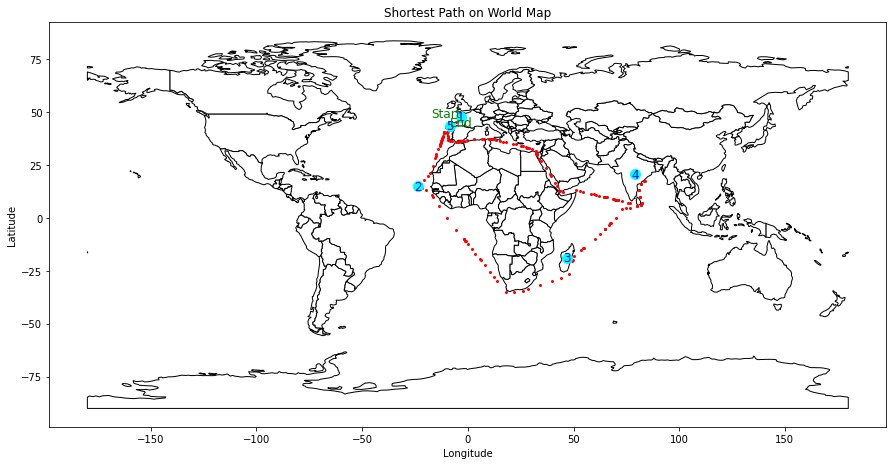

In [18]:
coordinates = [pl[i] for i in stops]
dests, orgs = [], []
for i in range(len(stops)-1):
    dests.append(pl[stops[i]])
    orgs.append(pl[stops[i+1]])
outputs = []
for i in range(len(coordinates)-1):
    outputs.extend(marnet_geograph.get_shortest_path(
    origin_node={"latitude": coordinates[i][0], "longitude": coordinates[i][1]}, 
    destination_node={"latitude": coordinates[i+1][0], "longitude": coordinates[i+1][1]}
)['coordinate_path'])
path = [[i[0], i[1]] for i in outputs]
lats, lons = zip(*path)

# Path to the shapefile
shapefile_path = os.path.join('natural_earth_vector', 'natural-earth-vector-5.0.1', 'geojson', 'ne_110m_admin_0_countries.geojson')

# Read the shapefile
world = gpd.read_file(shapefile_path)

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')

# Plot the route
ax.plot(lons, lats, color='red', linewidth=0, marker='o', markersize=2)

for i, (lat, lon) in enumerate(coordinates, start=1):
    ax.plot(lon, lat, color='cyan', marker='o', markersize=10)
    ax.text(lon, lat, str(i), fontsize=12, ha='center', va='center', color='blue')

# Annotate the start and end points
ax.text(lons[0], lats[0], 'Start', fontsize=12, ha='right', color='green')
ax.text(lons[-1], lats[-1], 'End', fontsize=12, ha='left', color='green')

# Set plot title and labels
plt.title('Shortest Path on World Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

file_name = voyage_code+'_vis.png'
plt.savefig(file_name, dpi=600, bbox_inches='tight')

plt.show()

Route from [20.5937, 78.9629] to [43.3623, -8.4115] intersects Suez Canal. Finding alternative route.


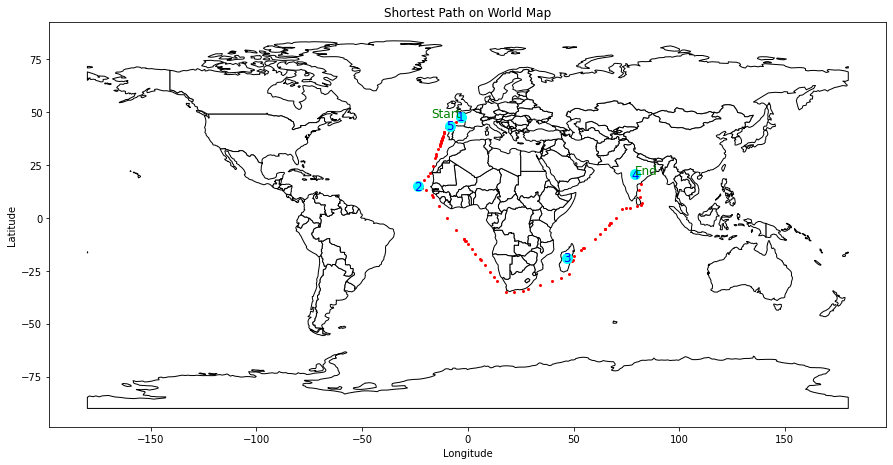

In [23]:
# Define the Suez Canal as a polygon (example coordinates, adjust as necessary)
suez_canal_polygon = Polygon([
    (32.5, 30.0), (32.6, 30.0), (32.6, 31.0), (32.5, 31.0), (32.5, 30.0)
])

# Update the path calculation to avoid the Suez Canal
outputs = []
for i in range(len(coordinates) - 1):
    path = marnet_geograph.get_shortest_path(
        origin_node={"latitude": coordinates[i][0], "longitude": coordinates[i][1]},
        destination_node={"latitude": coordinates[i + 1][0], "longitude": coordinates[i + 1][1]}
    )['coordinate_path']
    
    # Check if the path intersects the Suez Canal polygon
    path_line = LineString([(p[1], p[0]) for p in path])  # Note: (longitude, latitude)
    if path_line.intersects(suez_canal_polygon):
        print(f"Route from {coordinates[i]} to {coordinates[i + 1]} intersects Suez Canal. Finding alternative route.")
        # Implement logic to calculate an alternative route here.
        # You may add penalties or avoid specific nodes in the shortest path algorithm.
    else:
        outputs.extend(path)

# Proceed with visualization as before
path = [[p[0], p[1]] for p in outputs]
lats, lons = zip(*path)

# Path to the shapefile
shapefile_path = os.path.join('natural_earth_vector', 'natural-earth-vector-5.0.1', 'geojson', 'ne_110m_admin_0_countries.geojson')

# Read the shapefile
world = gpd.read_file(shapefile_path)

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')

# Plot the route
ax.plot(lons, lats, color='red', linewidth=0, marker='o', markersize=2)

for i, (lat, lon) in enumerate(coordinates, start=1):
    ax.plot(lon, lat, color='cyan', marker='o', markersize=10)
    ax.text(lon, lat, str(i), fontsize=12, ha='center', va='center', color='blue')

# Annotate the start and end points
ax.text(lons[0], lats[0], 'Start', fontsize=12, ha='right', color='green')
ax.text(lons[-1], lats[-1], 'End', fontsize=12, ha='left', color='green')

# Set plot title and labels
plt.title('Shortest Path on World Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

file_name = voyage_code+'_vis_alt.png'
plt.savefig(file_name, dpi=600, bbox_inches='tight')

plt.show()